# Character by Design: Exploring the Link Between Actor Traits and Movie Characters Archetypes

### Abstract 

The project goal is to explore the relationship between actors' traits — such as age, gender, ethnicity — and the character archetypes they portray in films. By analyzing casting patterns, this project aims to find out how specific actor profiles consistently coincide with archetypal roles like heroes, villains, mentors, or lovers. Our goal is to uncover whether certain traits predispose actors to particular roles and identify any underlying biases in casting decisions. This research also explores how these patterns vary across different film industries and across time. Ultimately, we aim to tell the story of how an actor's characteristics shape their cinematic destiny, influencing not only their career trajectory but also how audiences perceive iconic characters on screen.

## Analyzing the initial CMU dataset
Responsible: Seva

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import seaborn as sns

Firstly, let's download data and convert it to a convenient format. To do this, I've written a script `src/scripts/basic_process_cmu.py`

Also, there's a script for freebase dataset processing `src/scripts/download_freebase2wikidata.py`, but we're still working on it.

Data parsing and basic processing can be found there

In [14]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

--2024-11-15 20:30:45--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M   140KB/s    in 3m 8s   

2024-11-15 20:33:53 (250 KB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]



In [15]:
! mkdir -p ./data/MovieSummaries
! tar xvf ./MovieSummaries.tar.gz --strip-components=1 -C ./data/MovieSummaries

x tvtropes.clusters.txt
x name.clusters.txt
x plot_summaries.txt
x README.txt
x movie.metadata.tsv
x character.metadata.tsv


Now the processing script

In [24]:
! python ./src/scripts/basic_process_cmu.py \
    --data_dir ./data/MovieSummaries \
    --output_dir ./data/MovieSummaries \
    --process_movies_helper ./src/scripts/scripts_json_helpers/process_movies_helper.json \
    --process_actors_helper ./src/scripts/scripts_json_helpers/process_actors_helper.json \
    --process_ethnicities_helper ./src/scripts/scripts_json_helpers/process_ethnicities_helper.json

[INFO] Movie: languages are processed
[INFO] Movie: releases dates are processed
[INFO] Movie: countries are processed
[INFO] Movie: old2new countries are processed
[INFO] Movie: genres are processed
[INFO] Characters: (Actor date of birth) are processed
[INFO] Characters: (Movie release date) are processed
Process Ethnicities


## Characters NaN

In [17]:
char_processed = pd.read_csv(
    "./data/MovieSummaries/character_processed.csv",
    parse_dates=["actor_date_of_birth", "movie_release_date"],
)

First important information is amount of missing values:

In [11]:
char_processed.isna().sum(axis=0) / char_processed.shape[0]

Wikipedia movie ID                 0.000000
Freebase movie ID                  0.000000
Character name                     0.557159
Actor gender                       0.006152
Actor height (in meters)           0.553138
Actor ethnicity (Freebase ID)      0.705642
Actor name                         0.000039
Freebase character/actor map ID    0.000000
Freebase character ID              0.557147
Freebase actor ID                  0.000000
actor_date_of_birth                0.000000
movie_release_date                 0.000000
ethn_name                          0.742623
race                               0.742623
dtype: float64

As we can see there are a lot of missing values:
- Character name                     ~55%
- Actor height (in meters)           ~55%
- Freebase character ID              ~55%
- Actor ethnicity (Freebase ID)      ~70%
- ethn_name                          ~74%
- race                               ~74%

All these features correspond to actor's traits, wich are important to our project 

In [12]:
char_processed.isna().sum(axis=1).value_counts()

6    103185
4     54281
3     53046
5     44665
0     40255
2     26844
1     11133
7      1577
8         1
Name: count, dtype: int64

## Movies NaN

In [25]:
movies_processed = pd.read_csv(
    "./data/MovieSummaries/movie_processed.csv",
    parse_dates=["movie_release_date"],
)

In [19]:
movies_processed.isna().sum(axis=0) / movies_processed.shape[0]

Wikipedia movie ID          0.000000
Freebase movie ID           0.000000
Movie name                  0.000000
Movie box office revenue    0.897224
Movie runtime               0.250180
languages                   0.000000
movie_release_date          0.084437
countries_old               0.000000
countries                   0.000000
genres                      0.000000
dtype: float64

Let's also consider the number of NaN in plot_summaries

In [20]:
all_plots_wikiids = set()

with open("./data/MovieSummaries/plot_summaries.txt") as f:
    lines = f.read().splitlines()
    for line in lines:
        wikiid, plot_summ = line.split("\t")
        if len(plot_summ) > 0:
            all_plots_wikiids.add(int(wikiid))

len(set(movies_processed["Wikipedia movie ID"].values.tolist()) - all_plots_wikiids) / len(movies_processed)

0.4836495761001211

- Movie box office revenue    ~90%
- Movie runtime               ~25%
- movie_release_date          ~10%
- plot_summary                ~50%

That's quite a big fraction of nans, so data enrichment methods should be used.

## Descriptive statistics for characters

In [18]:
char_processed = char_processed.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

char_processed

,wikipedia_movie_id,fb_movie_id,character_name,actor_gender,actor_height,fb_actor_eth_id,actor_name,fb_char_actor_map_id,fb_char_id,fb_actor_id,actor_date_of_birth,movie_release_date,ethn_name,race
0,975900,/m/03vyhn,Akooshay,F,1.620,NaN,Wanda De Jesus,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,1958-08-26,2001-08-24,NaN,NaN
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,F,1.780,/m/044038p,Natasha Henstridge,/m/0jys3m,/m/0bgchn4,/m/0346l4,1974-08-15,2001-08-24,NaN,NaN
2,975900,/m/03vyhn,Desolation Williams,M,1.727,/m/0x67,Ice Cube,/m/0jys3g,/m/0bgchn_,/m/01vw26l,1969-06-15,2001-08-24,African American,African
3,975900,/m/03vyhn,Sgt Jericho Butler,M,1.750,NaN,Jason Statham,/m/02vchl6,/m/0bgchnq,/m/034hyc,1967-09-12,2001-08-24,NaN,NaN
4,975900,/m/03vyhn,Bashira Kincaid,F,1.650,NaN,Clea DuVall,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,1977-09-25,2001-08-24,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334982,913762,/m/03pcrp,UN Spacy Commander,M,NaN,NaN,Sonny Byrkett,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1954-01-01,1992-05-21,NaN,NaN
334983,913762,/m/03pcrp,Silvie Gena,F,NaN,NaN,Susan Byrkett,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1958-01-01,1992-05-21,NaN,NaN
334984,913762,/m/03pcrp,Elensh,F,NaN,NaN,Dorothy Elias-Fahn,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1970-05-01,1992-05-21,NaN,NaN
334985,913762,/m/03pcrp,Hibiki,M,NaN,NaN,Jonathan Fahn,/m/0kr405_,/m/0kr4090,/m/0bx7_j,1965-04-12,1992-05-21,NaN,NaN


Get the independent pandas table (dont look at the movies ids)

In [19]:
char_indep = char_processed[["actor_gender", "actor_height", "actor_name", "actor_date_of_birth", "fb_actor_id", "ethn_name", "race"]].drop_duplicates(subset=["fb_actor_id"])

In [20]:
char_indep.shape

(58176, 7)

In [21]:
char_indep["actor_gender"].value_counts()

actor_gender
M    36053
F    21022
Name: count, dtype: int64

We need to drop some values which are too high and not realistic

In [22]:
char_indep.loc[char_indep["actor_height"] > 3, "actor_height"] = char_indep.loc[char_indep["actor_height"] <= 3, "actor_height"].max()

In [23]:
char_indep[["actor_height", "actor_gender"]].groupby(by="actor_gender").describe()

actor_height                                                     
                    count      mean       std    min   25%   50%    75%    max
actor_gender                                                                  
F                  5541.0  1.658681  0.077256  0.610  1.60  1.66  1.702  1.910
M                  6700.0  1.800782  0.100692  0.813  1.75  1.80  1.850  2.356

In [24]:
char_indep[['actor_height', 'actor_name']].sort_values(by='actor_height', ascending=True).head(10)

,actor_height,actor_name
328376,0.610,Shelby Hoffman
328375,0.610,Kara Hoffman
6664,0.813,Verne Troyer
23365,0.830,Weng Weng
15070,0.880,Angelo Rossitto
91266,0.940,Ian Michael Smith
74137,1.000,Laurent Lucas
82771,1.060,Taylor Geare
57257,1.060,Arturo Gil
3475,1.067,Phil Fondacaro


It is noticeable that M are higher than F, but let's consider that's going on in every race

<Axes: xlabel='actor_gender', ylabel='actor_height'>

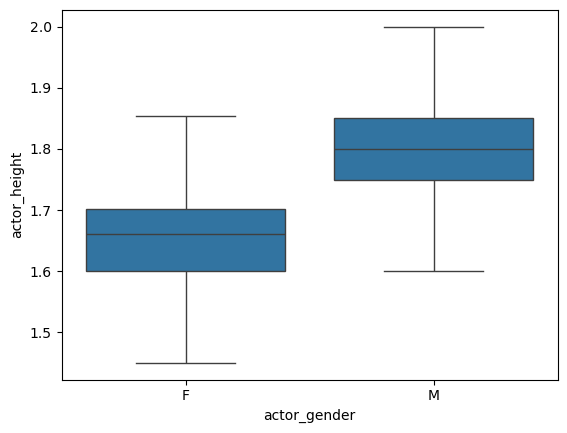

In [25]:
sns.boxplot(data=char_indep, x="actor_gender", y="actor_height", showfliers=False)

M is higher than F noticeably almost for every race except Carribean, where they are almost the same

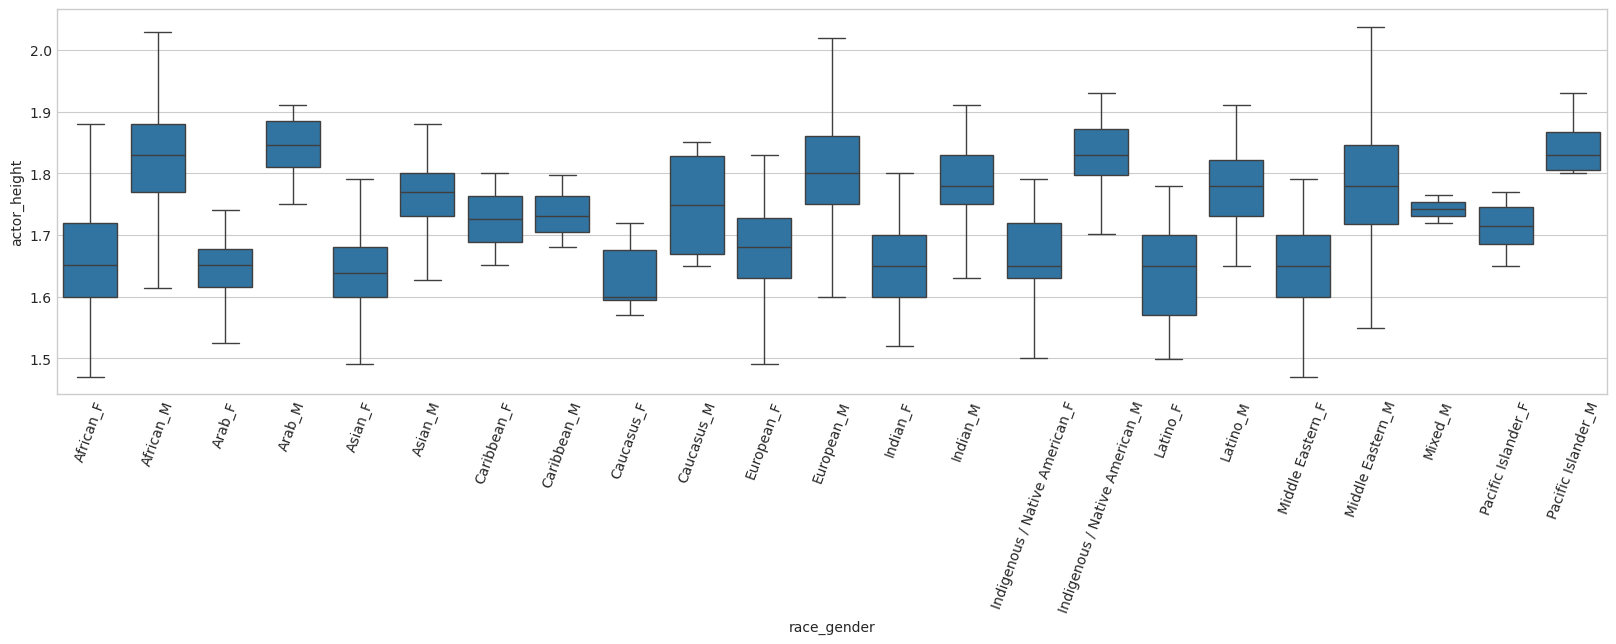

In [27]:
char_indep["race_gender"] = char_indep["race"] + "_" + char_indep["actor_gender"]

with plt.style.context("seaborn-v0_8-whitegrid"):
    plt.figure(figsize=(20, 5))

    sns.boxplot(
        data=char_indep,
        x="race_gender",
        y="actor_height",
        showfliers=False,
        order=char_indep["race_gender"].dropna().sort_values().unique()
    )
    plt.xticks(rotation=70)

Now let's consider the ratio between M and F in every race.\
It can be seen that the ratios are almost the same in the Asian group. They are completely different in Carribean group, where more than 70% of actors are male.

In [28]:
char_indep_gender_by_race = char_indep[["actor_gender", "race"]].groupby("race")["actor_gender"].value_counts().unstack(fill_value=0).reset_index()
char_indep_gender_by_race["total"] = char_indep_gender_by_race[["F", "M"]].sum(axis=1)

char_indep_gender_by_race["F"] /= char_indep_gender_by_race["total"]
char_indep_gender_by_race["M"] /= char_indep_gender_by_race["total"]

<Axes: title={'center': 'Gender by race'}, ylabel='race'>

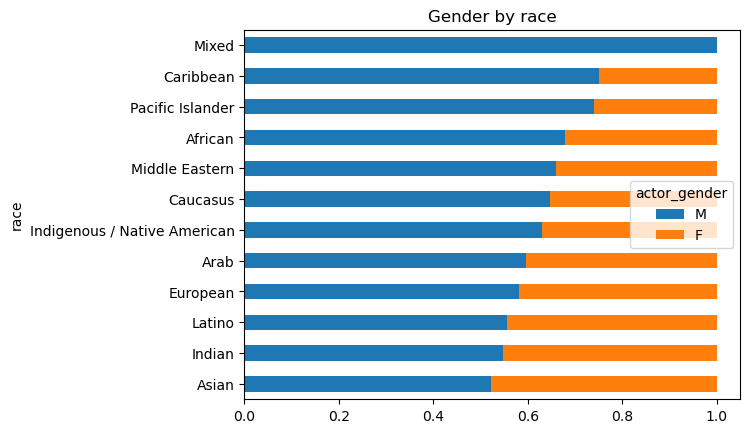

In [29]:
char_indep_gender_by_race[["race", "M", "F"]].sort_values(by="M", ascending=True).plot(
    x="race",
    kind="barh",
    stacked=True,
    title="Gender by race",
    mark_right=True,
)

It also might be instumental to know the distribution of races.\
It can be seen that Europeans are the hugest part, and together with Africans they are about 60% of the whole races distribution

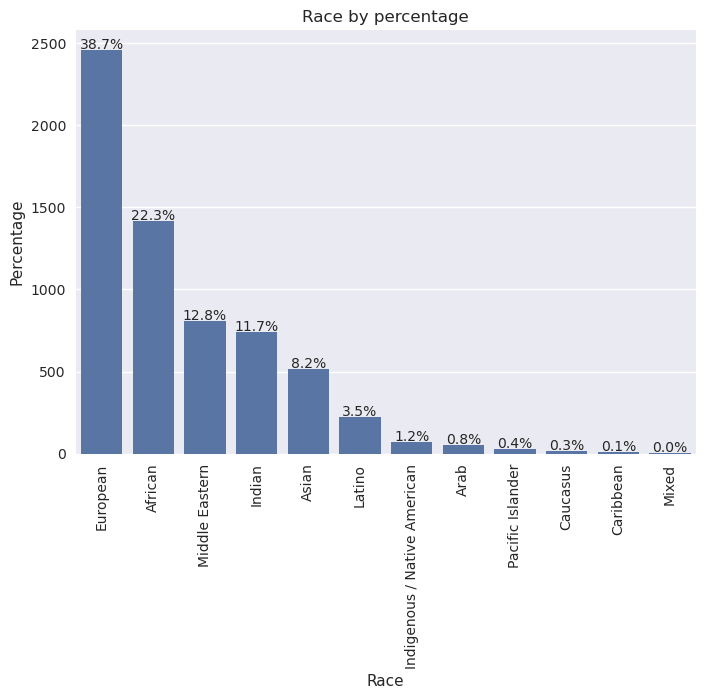

In [30]:
# Taken from https://www.kaggle.com/code/werooring/nfl-big-data-bowl-basic-eda-for-beginner
def write_percent(ax, total_size):
    '''Traverse the figure object and display the ratio at the top of the bar graph.'''
    for patch in ax.patches:
        height = patch.get_height() # Figure height (number of data)
        width = patch.get_width() # Figure width
        left_coord = patch.get_x() # The x-axis position on the left edge of the figure
        percent = height/total_size*100 # percent

        # Type text in the (x, y) coordinates
        ax.text(x=left_coord + width/2.0, # x-axis position
                y=height + total_size*0.001, # y-axis position
                s=f'{percent:1.1f}%', # Text
                ha='center') # in the middle


with plt.style.context('seaborn-v0_8'):
    plt.title("Race by percentage")
    ax = sns.countplot(x=char_indep.race, order=char_indep.race.value_counts().sort_values(ascending=False).index)
    write_percent(ax, len(char_indep.race.dropna()))
    plt.xlabel("Race")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage")

We plan to also look at the distribution of date of births.\
One can notice that the it has mode at ~1970. \
Surprusingly, the peacks for M and F are different (1970 and 1980 respectively).\


*The peak might be because of the following reasons:*
1. *Movie industry became much more famous*
2. *The overall population was increasing*
3. *And much more, we do not know a lot about History of that time...*

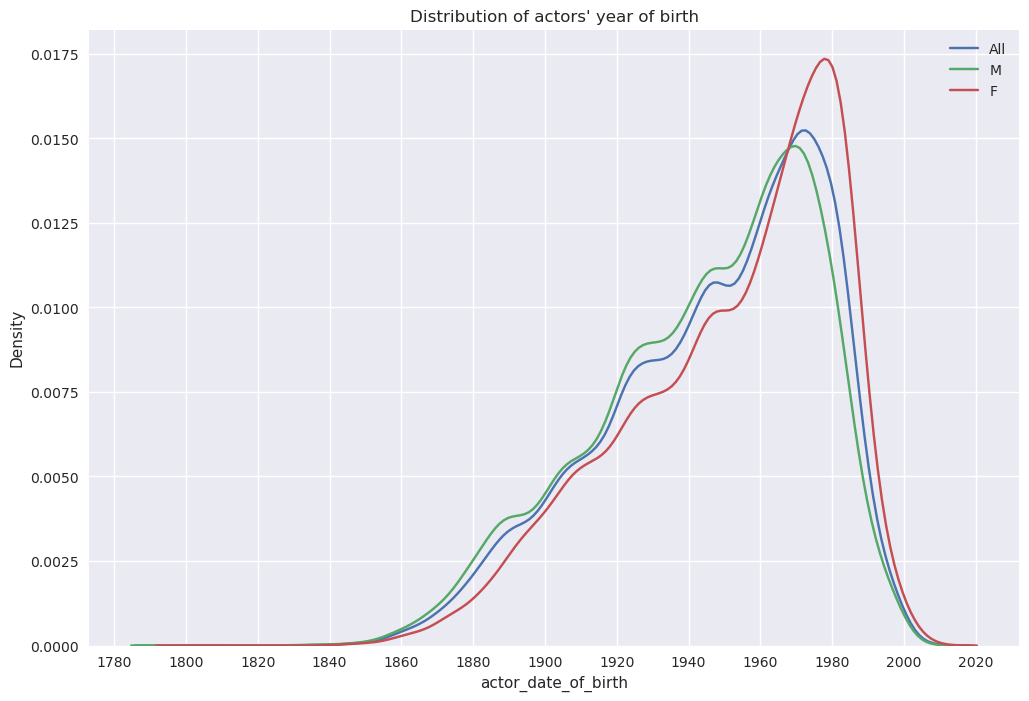

In [31]:
with plt.style.context('seaborn-v0_8'):
    plt.figure(figsize=(12, 8))
    plt.title("Distribution of actors' year of birth")
    sns.kdeplot(char_indep.actor_date_of_birth.dt.year, label="All")
    sns.kdeplot(char_indep.query("actor_gender=='M'").actor_date_of_birth.dt.year, label="M")
    sns.kdeplot(char_indep.query("actor_gender=='F'").actor_date_of_birth.dt.year, label="F")
    plt.xticks(ticks=[i for i in range(1780, 2021, 20)])
    plt.legend()

## Descriptive statistics for movies

In [32]:
movies_processed.rename(columns={
    "Wikipedia movie ID": "wikipedia_movie_id",
    "Freebase movie ID": "fb_movie_id",
    "Movie name": "movie_name",
    "Movie box office revenue": "revenue",
    "Movie runtime": "movie_runtime",
}, inplace=True)

In [33]:
movies_processed

,wikipedia_movie_id,fb_movie_id,movie_name,revenue,movie_runtime,languages,movie_release_date,countries_old,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,['english'],2001-08-24,['United States of America'],['United States of America'],"['Adventure', 'Horror', 'Action', 'Thriller', ..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,['english'],2000-02-16,['United States of America'],['United States of America'],"['Crime', 'Drama', 'Mystery', 'Biography']"
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,['norwegian'],1988-01-01,['Norway'],['Norway'],"['Crime', 'Drama']"
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,['english'],1987-01-01,['United Kingdom'],['United Kingdom'],"['Erotic', 'Thriller']"
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,['german'],1983-01-01,['Germany'],['Germany'],['Drama']
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,['english'],2011-03-19,['United States of America'],['United States of America'],['Drama']
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,['english'],2011-01-21,"['Ireland', 'United Kingdom']","['Ireland', 'United Kingdom']","['Documentary', 'Drama', 'Biography']"
81738,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,['english'],1972-09-22,['United States of America'],['United States of America'],"['Comedy', 'Satire']"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,['japanese'],1992-05-21,['Japan'],['Japan'],"['Drama', 'Adventure', 'Short Film', 'Cartoon'..."


Let's check out some simple distributions and statistics

In [34]:
movies_processed.sort_values(by="revenue", ascending=False).head(10)[["movie_name", "revenue"]]

,movie_name,revenue
23702,Avatar,2.782275e+09
22256,Titanic,2.185372e+09
28192,The Avengers,1.511758e+09
30278,Harry Potter and the Deathly Hallows – Part 2,1.328111e+09
18645,Transformers: Dark of the Moon,1.123747e+09
80920,The Lord of the Rings: The Return of the King,1.119930e+09
54719,The Dark Knight Rises,1.078009e+09
69586,Toy Story 3,1.063172e+09
14303,Pirates of the Caribbean: On Stranger Tides,1.043872e+09
50039,Star Wars Episode I: The Phantom Menace,1.027045e+09


In [35]:
movies_processed.sort_values(by="movie_runtime", ascending=False).head(10)[["movie_name", "movie_runtime"]]

,movie_name,movie_runtime
12804,Zero Tolerance,1079281.00
62962,Modern Times Forever,14400.00
71100,Cinématon,9360.00
21733,Matrjoschka,5700.00
46666,The Cure for Insomnia,5220.00
16316,Paradise in Harlem,5100.00
27036,Kai Koduttha Dheivam,4875.27
68223,The Longest Most Meaningless Movie in the World,2880.00
73658,Gigantor,2425.00
73630,Dil Ne Phir Yaad Kiya,1966.00


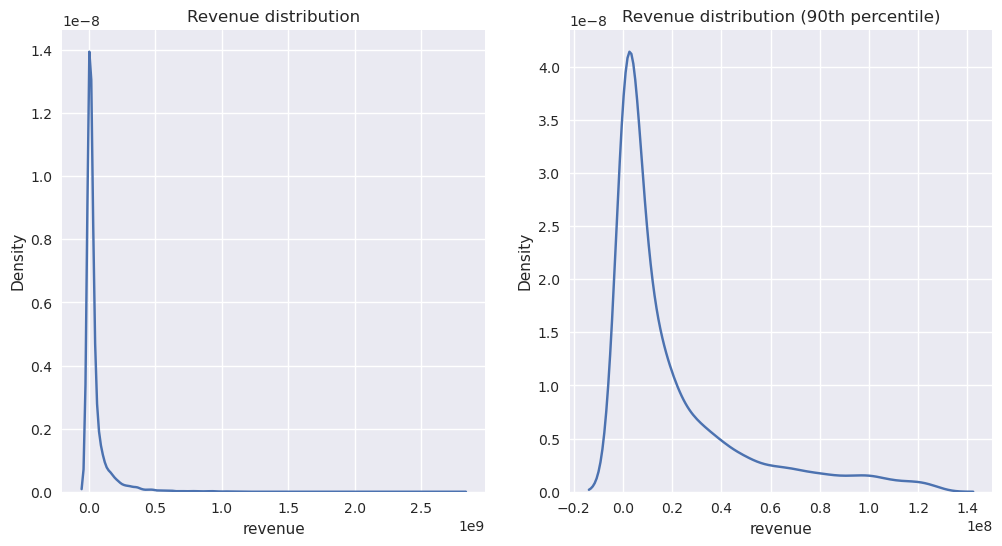

In [36]:
with plt.style.context("seaborn-v0_8"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Revenue distribution")
    sns.kdeplot(movies_processed["revenue"])
    plt.subplot(1, 2, 2)
    plt.title("Revenue distribution (90th percentile)")
    sns.kdeplot(movies_processed["revenue"][movies_processed["revenue"] < movies_processed["revenue"].quantile(0.9)])

It is also usefull to check out the distribution of genres, languages, and countries.

1. The most frequent genre is Drama (17%), then Comedy (10%), then Romance, Action, Thriller (5%)
2. The most frequent language is english (50%), then hindi, spanish, french (4.5%)
3. The most frequent country is US (40%), India and UK (10%), then France, Germany and Italy (4-5%)

100%|██████████| 81741/81741 [00:01<00:00, 46302.74it/s]


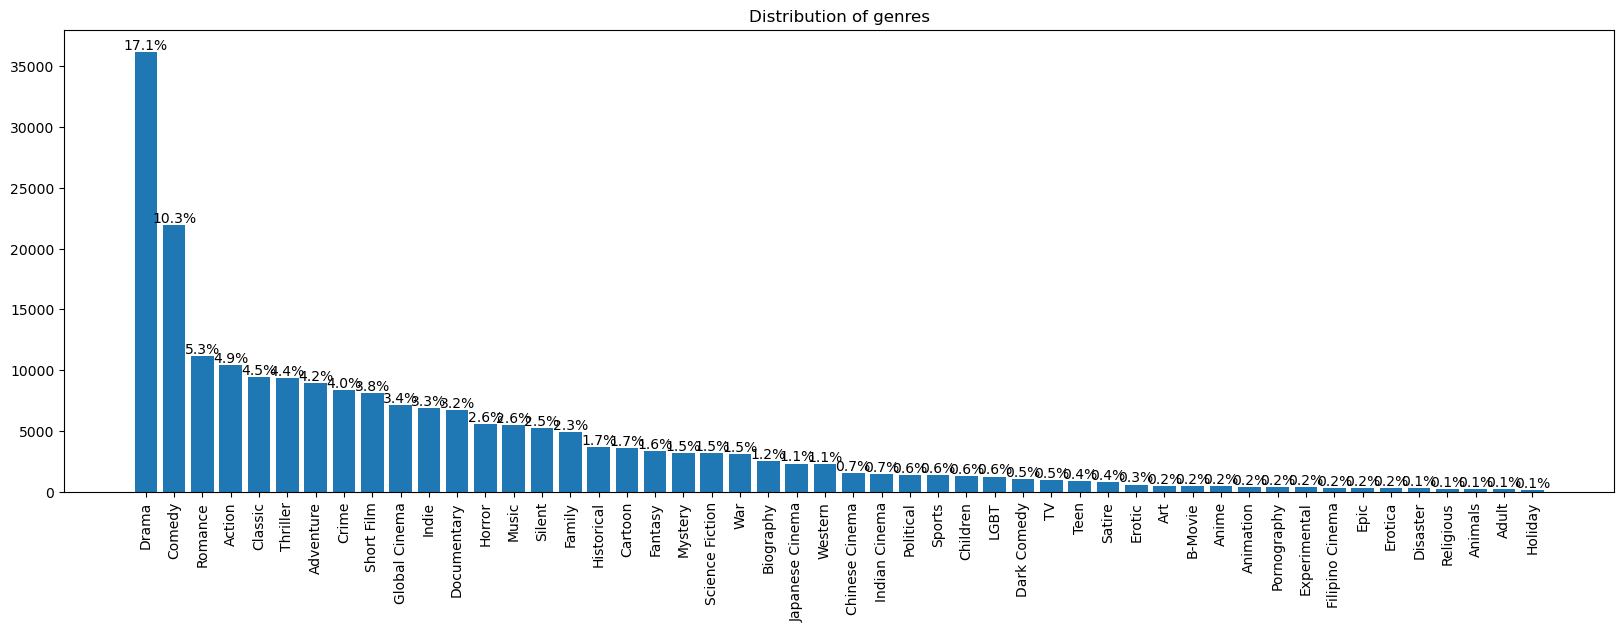

100%|██████████| 81741/81741 [00:01<00:00, 56252.77it/s]


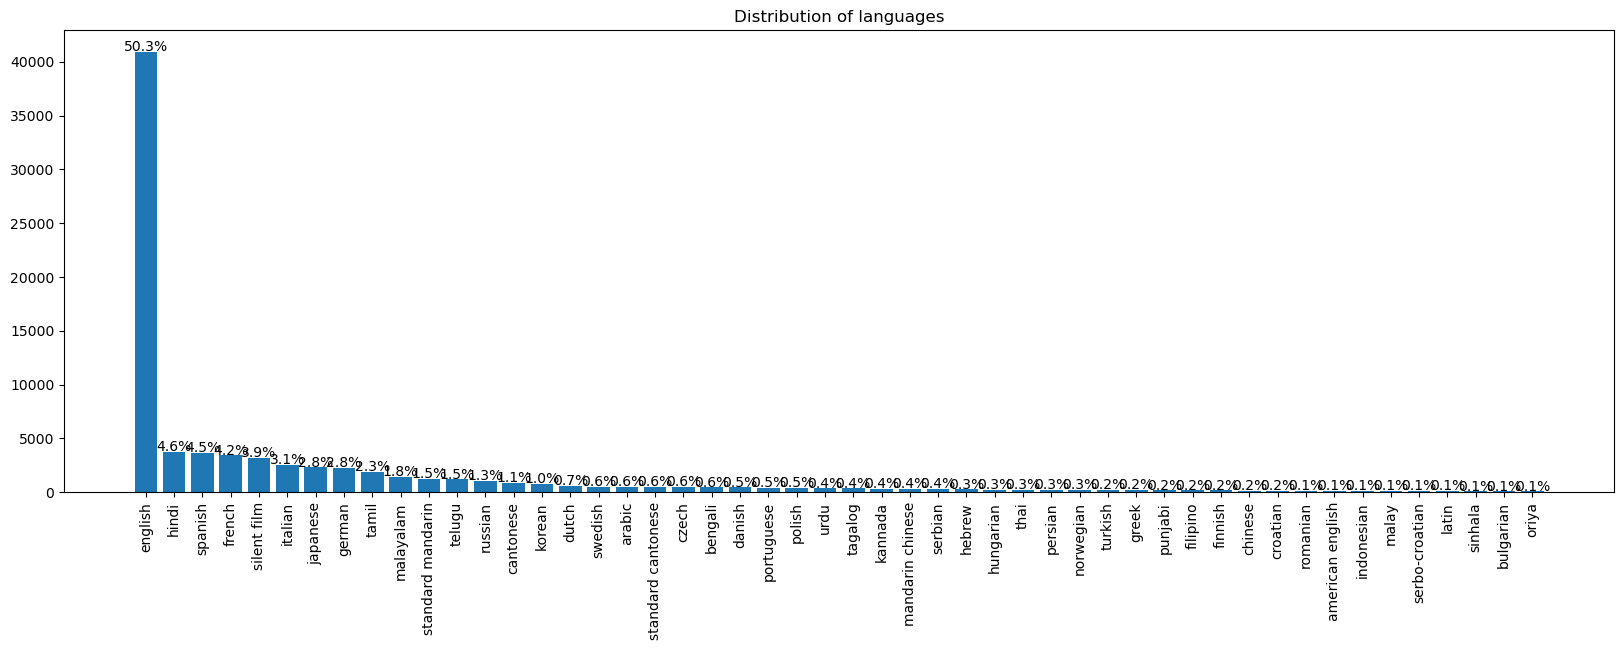

100%|██████████| 81741/81741 [00:01<00:00, 48983.95it/s]


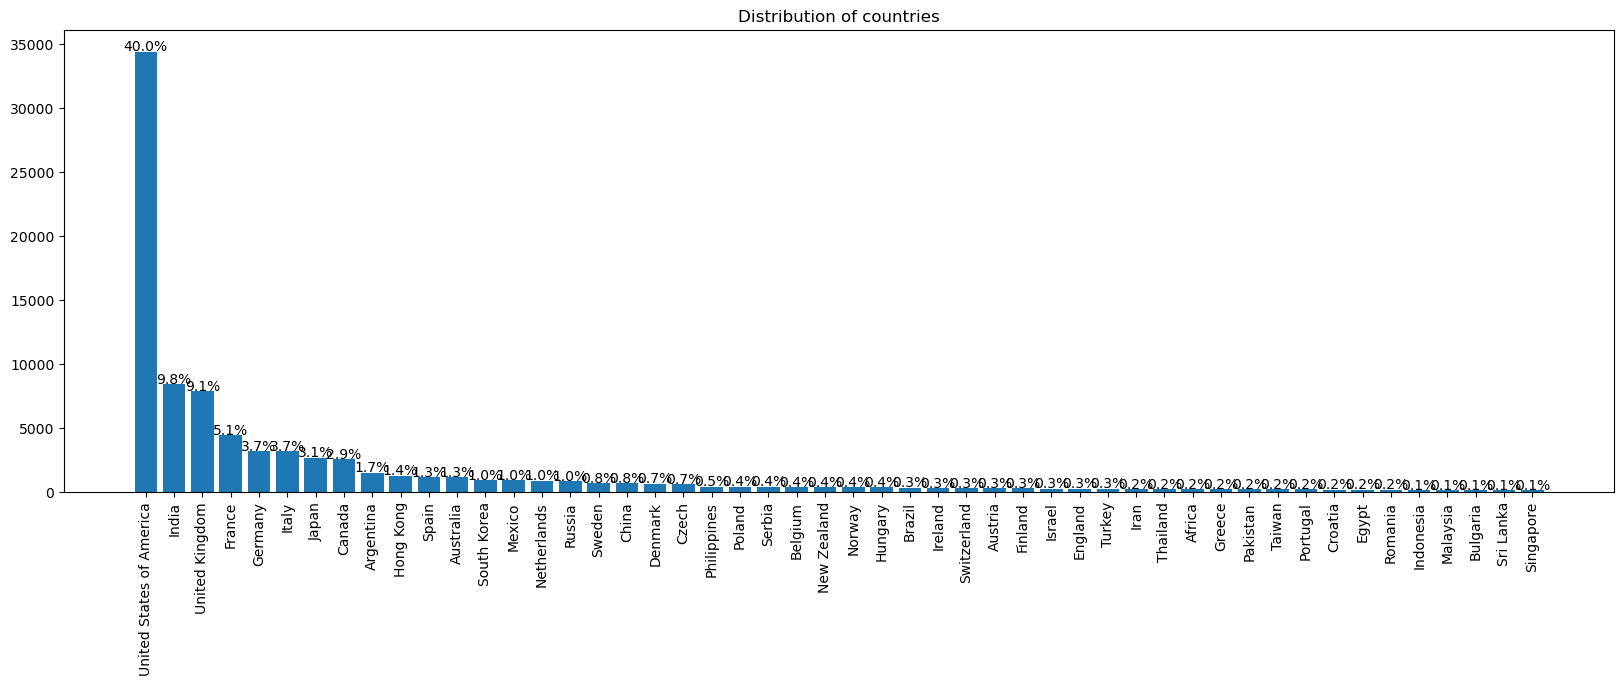

In [37]:
def get_distribution_from_list(data, column_of_list):
    data = data.copy().dropna(subset=[column_of_list])
    list_to_values = {}
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        for el in eval(row[column_of_list]):
            if not el in list_to_values:
                list_to_values[el] = 0
            list_to_values[el] += 1
    result = pd.DataFrame(pd.Series(list_to_values)).reset_index().rename(columns={0: "value", "index": "smth"})
    result.sort_values("value", ascending=False, inplace=True)
    result_cut = result.iloc[:50]
    plt.bar(result_cut["smth"], result_cut["value"])
    write_percent(plt.gca(), result["value"].sum())
    plt.xticks(rotation=90)

for column in ["genres", "languages", "countries"]:
    plt.figure(figsize=(20, 6))
    plt.title(f"Distribution of {column}")
    get_distribution_from_list(movies_processed, column)
    plt.show()

In [38]:
def list_to_values(data, column_of_list, column_value, use_sum):
    data = data.copy()
    list_to_values = {}
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        value = row[column_value]
        if value is None:
            continue
        for el in eval(row[column_of_list]):
            if not el in list_to_values:
                list_to_values[el] = []
            list_to_values[el].append(value)

    for key in list_to_values:
        if use_sum:
            list_to_values[key] = np.sum(list_to_values[key])
        else:
            list_to_values[key] = np.median(list_to_values[key])
    return pd.DataFrame(pd.Series(list_to_values)).reset_index().rename(columns={0: "value", "index": "smth"})

def get_distribution_by(data, column=None, func_to_apply=None, column_to_apply=None, title="", use_sum=False):
    '''
    This function helps to get the distribution of the data by:
    1. Year
    2. County
    3. Genre
    4. Language

    It also plots the distribution of the data by the above-mentioned categories.
    '''
    data = data.copy().dropna(subset=[column])
    if not func_to_apply is None:
        data[column] = data[column_to_apply].apply(func_to_apply)

    # by year
    data["year"] = data["movie_release_date"].dt.year
    if use_sum:
        by_year = pd.DataFrame(data.groupby("year")[column].sum()).reset_index()
    else:
        by_year = pd.DataFrame(data.groupby("year")[column].mean()).reset_index()

    # by country
    by_country = list_to_values(data, "countries", column, use_sum=use_sum)

    # by genre
    by_genre = list_to_values(data, "genres", column, use_sum=use_sum)

    # by language
    by_language = list_to_values(data, "languages", column, use_sum=use_sum)

    with plt.style.context("seaborn-v0_8"):
        plt.figure(figsize=(15, 30))
        plt.suptitle(title)
        for i, by_smth, name in zip(
                [0, 1, 2, 3],
                [by_year, by_country, by_genre, by_language], ["year", "country", "genre", "language"]
            ):
            plt.subplot(4, 1, i + 1)
            plt.title(name)
            if i == 0:
                by_smth = by_smth.sort_values("year")
                xname = "year"
                yname = column
            else:
                by_smth = by_smth.sort_values("value", ascending=False)
                xname = "smth"
                yname = "value"
                by_smth = by_smth.iloc[:50]
            plt.plot(by_smth[xname], by_smth[yname])
            plt.xticks(rotation=90, ha='right')
        plt.tight_layout(rect=[0, 0.01, 1, 0.95])
    return by_year, by_country, by_genre, by_language

1. Revenue increases throughout the years
2. US, UK have the biggest revenue
3. Adventure and Drama genres have the biggest revenue
4. Cinemas made in english have the biggest revenue

100%|██████████| 8401/8401 [00:00<00:00, 33890.59it/s]


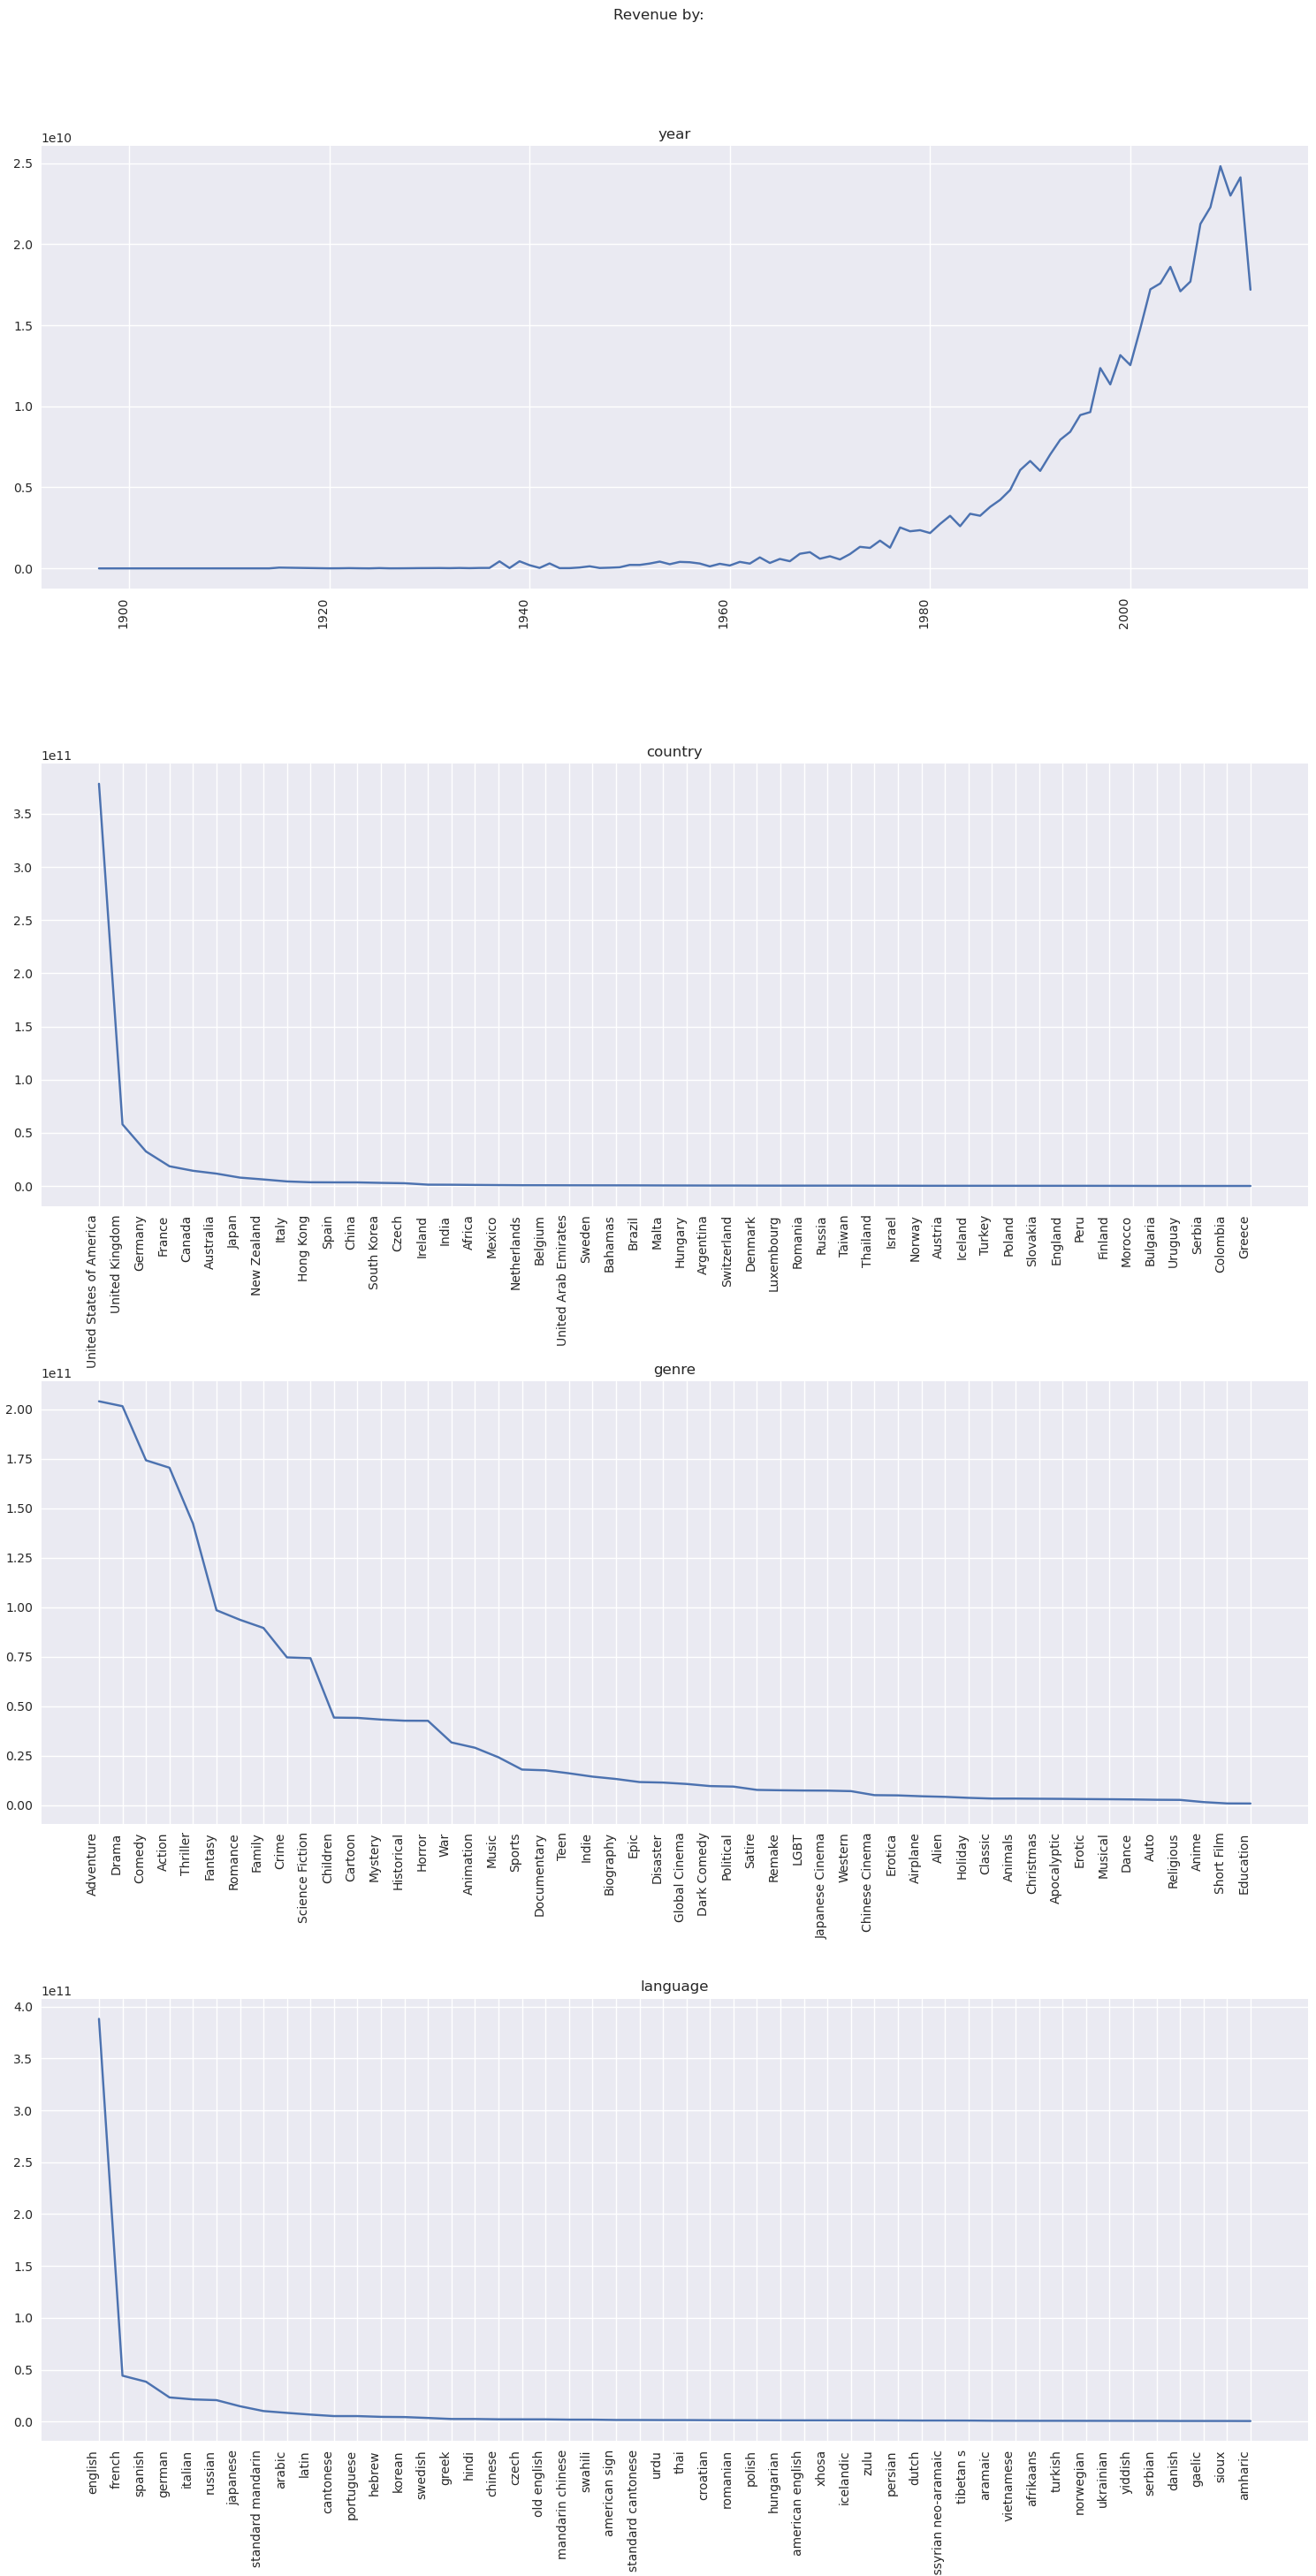

In [39]:
get_distribution_by(movies_processed, "revenue", title="Revenue by:", use_sum=True);

Let's also consider the **average** revenue

1. Average revenue increases throughout the years
2. For some reason Bahamas, Malta and Peru have the biggest average revenue
3. Apocalyptic genre has the biggest Average revenue
4. Cinemas made in old english have the biggest average revenue

  0%|          | 0/8401 [00:00<?, ?it/s]

100%|██████████| 8401/8401 [00:00<00:00, 52415.54it/s]


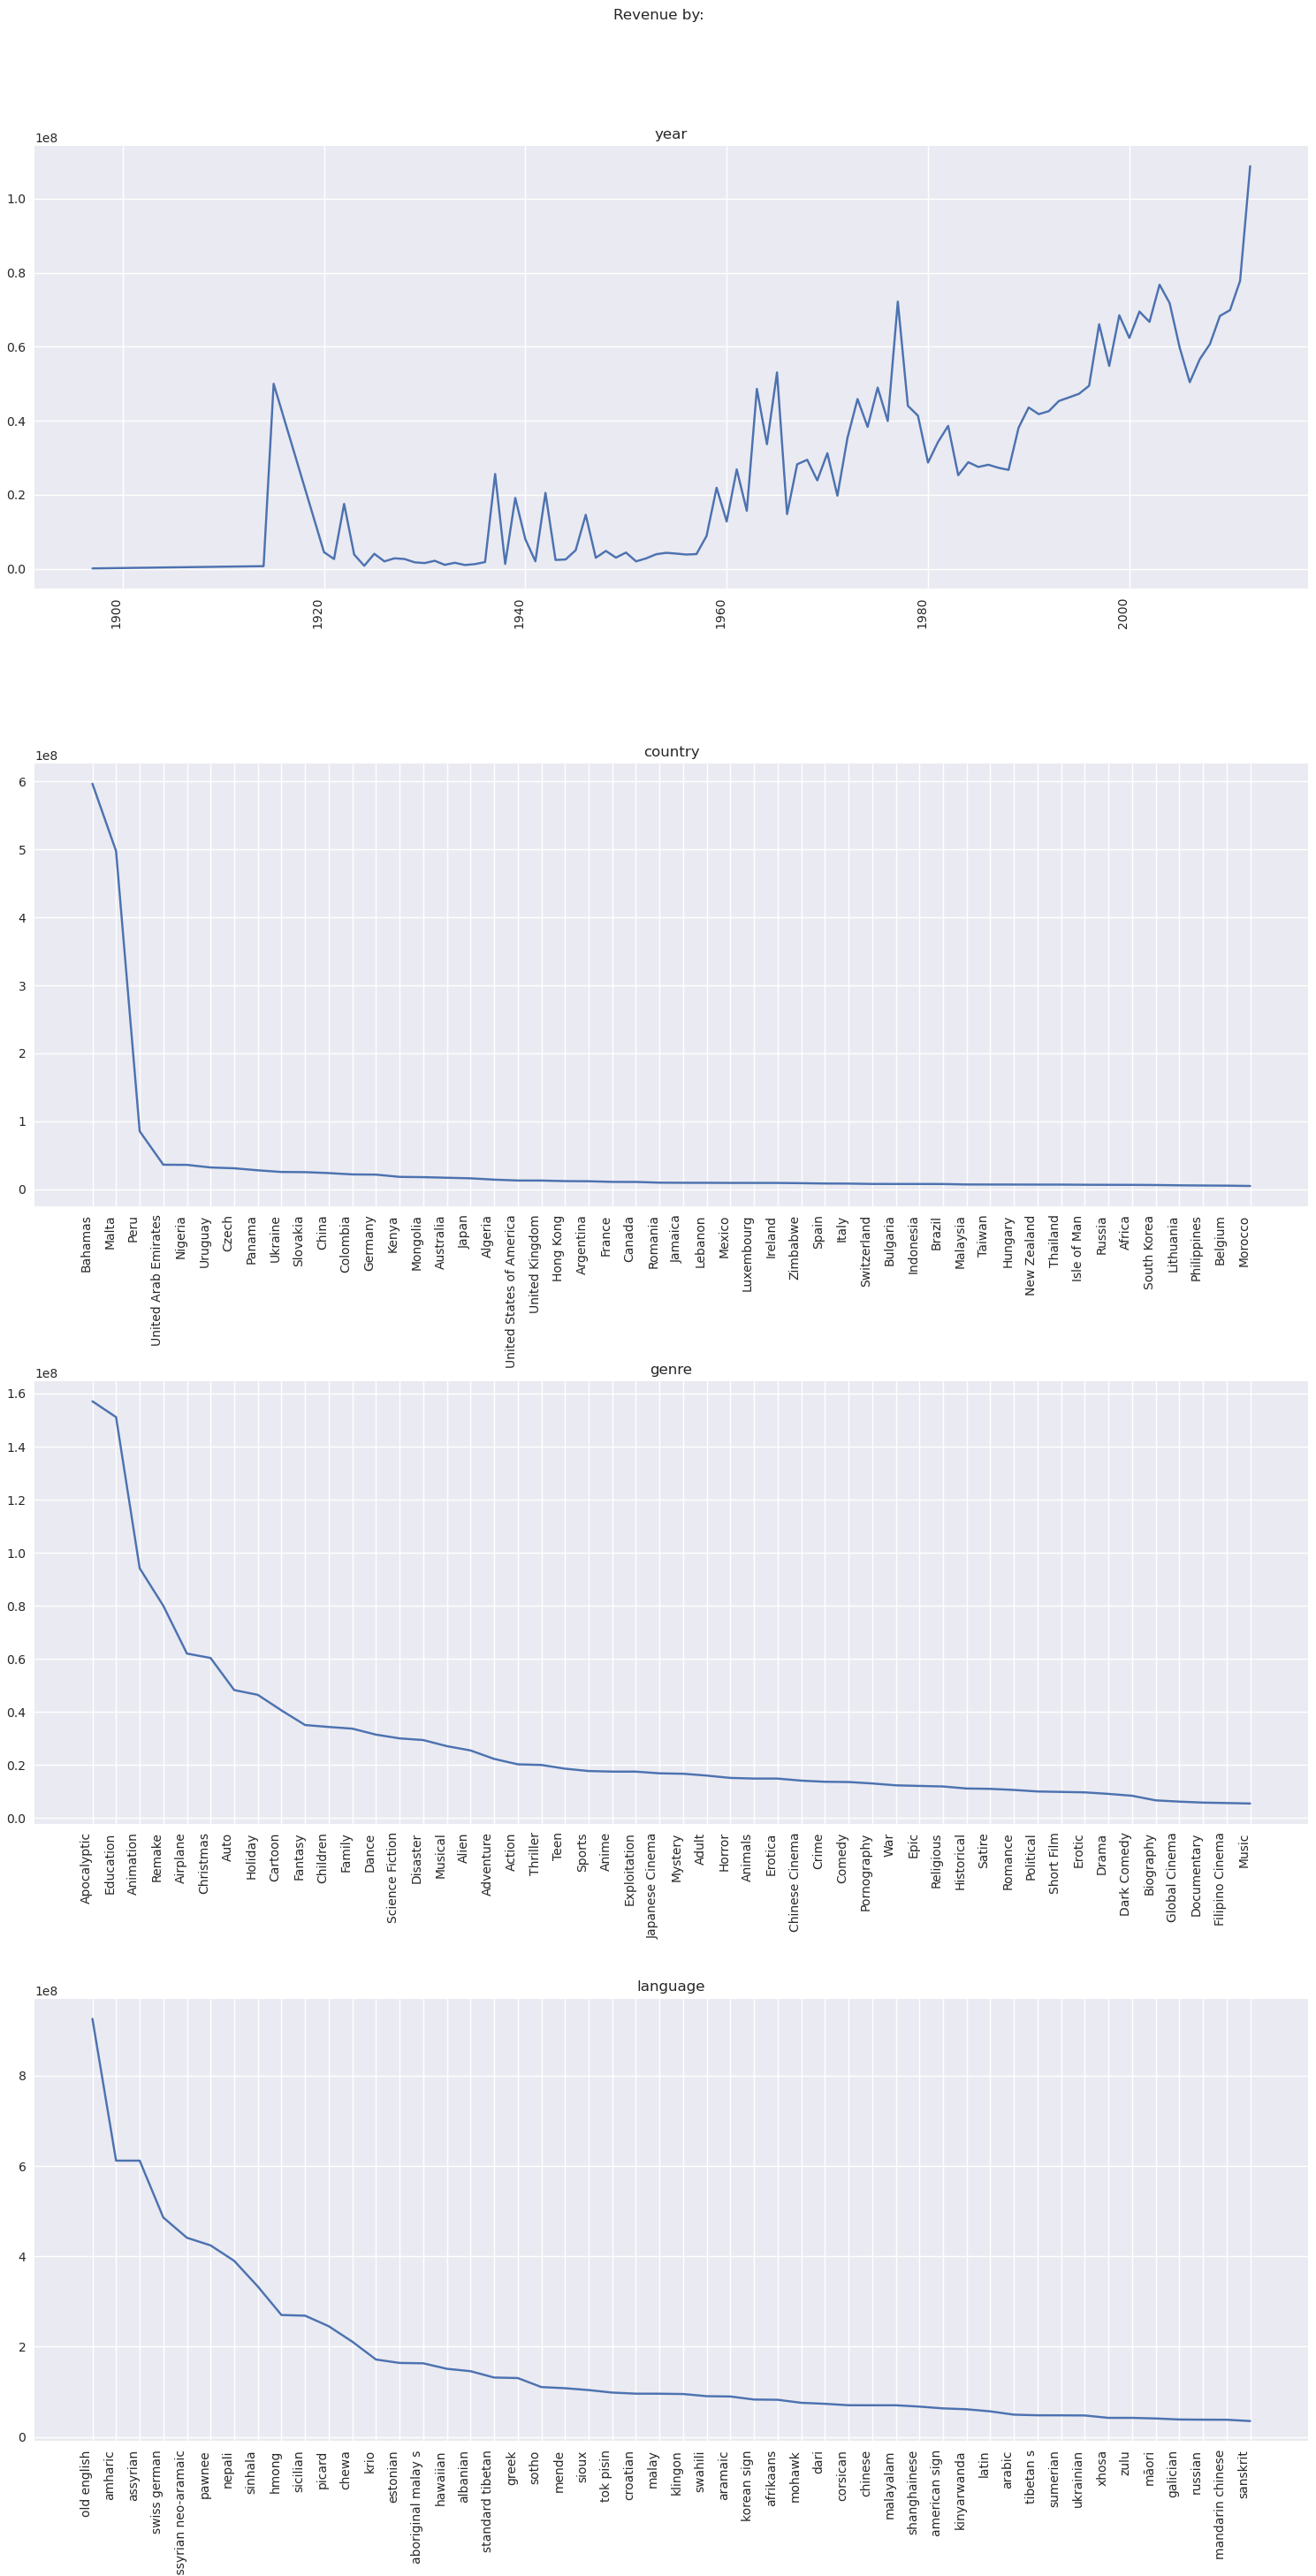

In [40]:
get_distribution_by(movies_processed, "revenue", title="Revenue by:", use_sum=False);

1. Runtime increases throughout the years
2. Libya and some Indian countries (or countries which are close to it) have the biggest runtime.
3. Serial have the highest runtime (obviously), then its indian cinema

  0%|          | 0/61291 [00:00<?, ?it/s]

100%|██████████| 61291/61291 [00:09<00:00, 6504.73it/s]


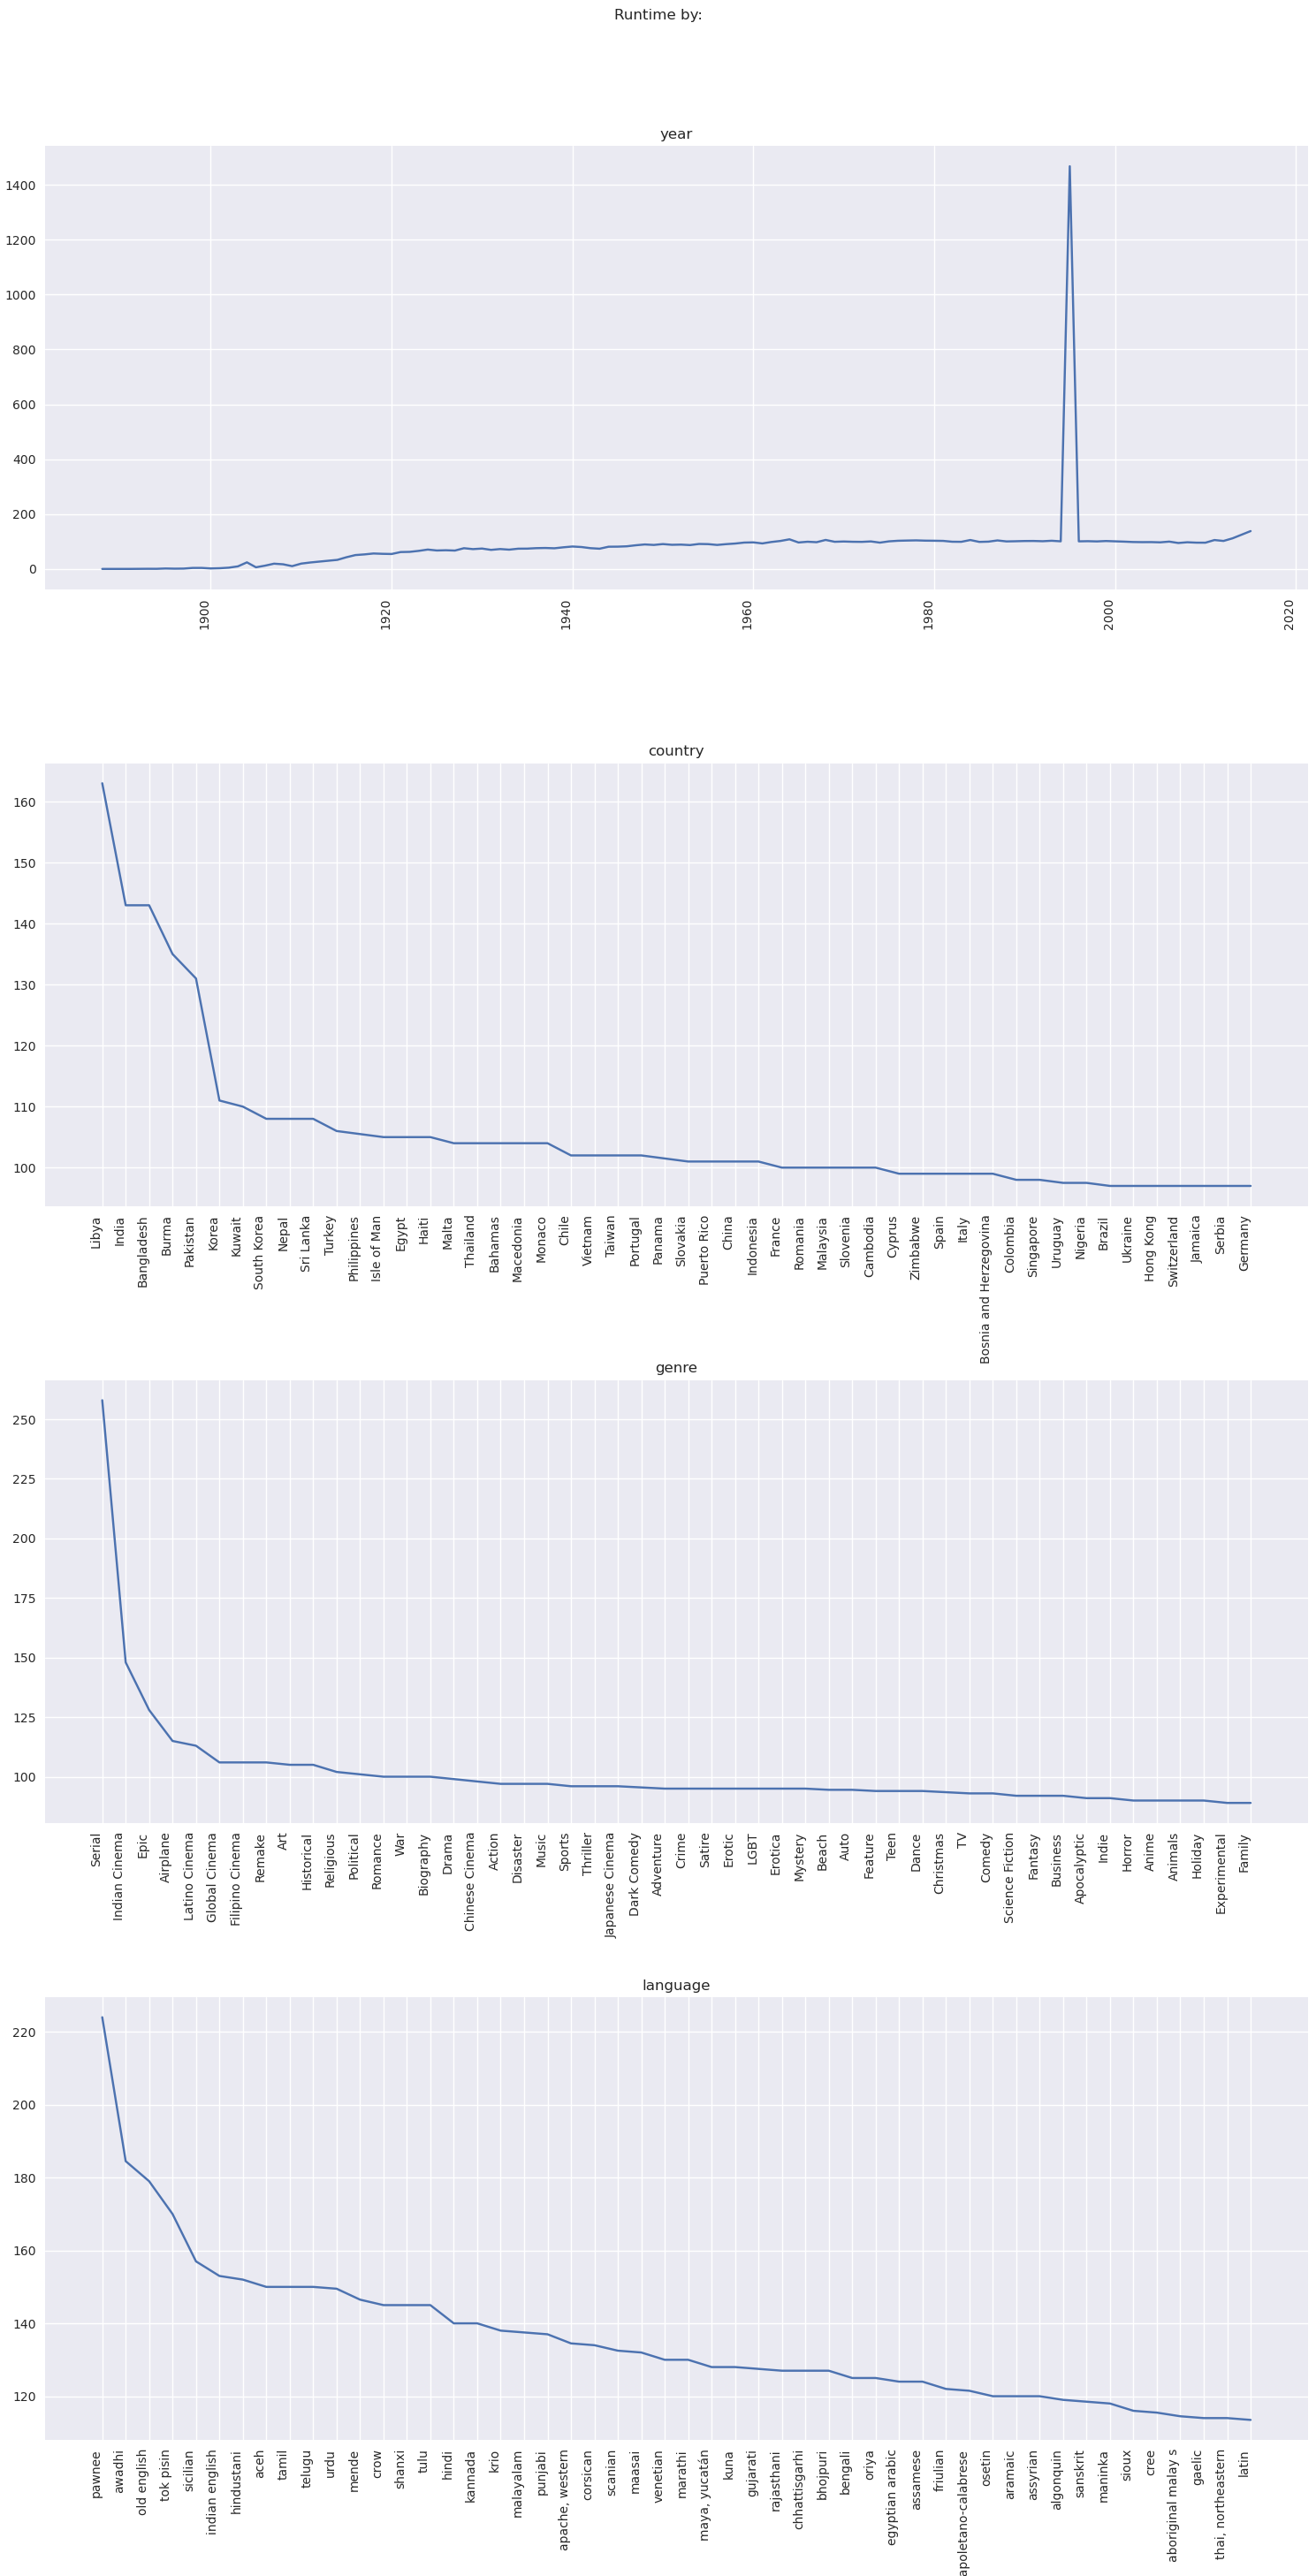

In [ ]:
get_distribution_by(movies_processed, "movie_runtime", title="Runtime by:");

Average number of languages by film throughout the time:

We see one significant drop in 1930s and slight increase until the second drop in 2010s 

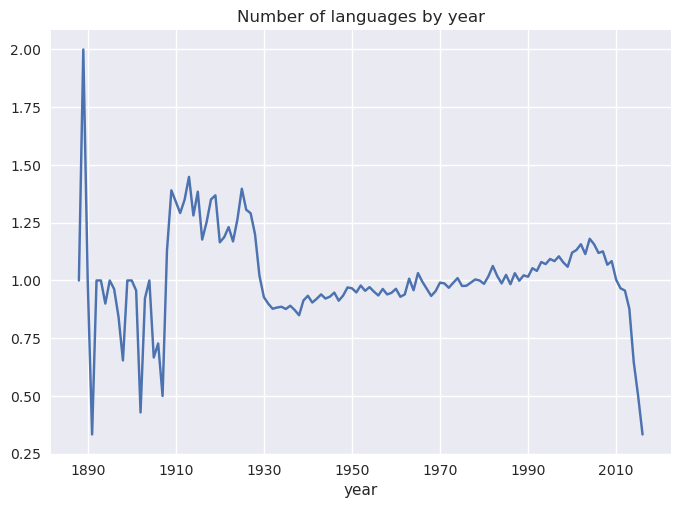

In [ ]:
with plt.style.context("seaborn-v0_8"):
    movies_processed["year"] = movies_processed["movie_release_date"].dt.year
    movies_processed["language_num"] = movies_processed["languages"].apply(lambda x: len(eval(x)))
    movies_processed[["year", "language_num"]].groupby("year")["language_num"].mean().plot(x="year", y="language_num", title="Number of languages by year")
    plt.xticks(ticks=[i for i in range(1890, 2021, 20)]);

Average number of genres by film throughout the time:

Slight decrease until 1950 and then slight increase until 2010

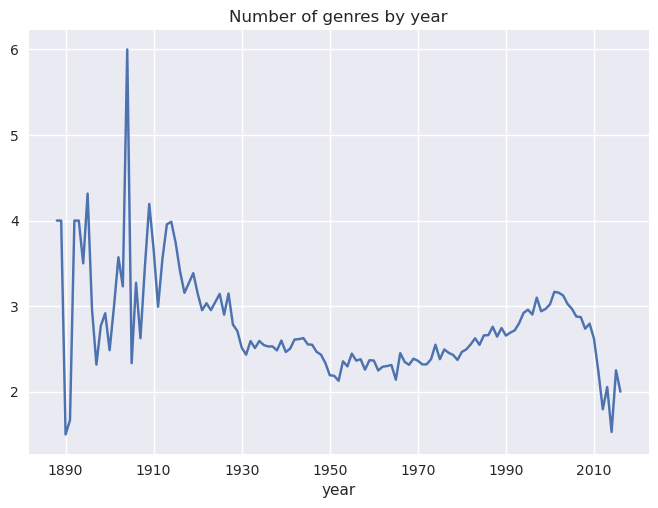

In [ ]:
with plt.style.context("seaborn-v0_8"):
    movies_processed["year"] = movies_processed["movie_release_date"].dt.year
    movies_processed["genre_num"] = movies_processed["genres"].apply(lambda x: len(eval(x)))
    movies_processed[["year", "genre_num"]].groupby("year")["genre_num"].mean().plot(x="year", y="genre_num", title="Number of genres by year")
    plt.xticks(ticks=[i for i in range(1890, 2021, 20)]);

It is also quite interesting to look at how the average number of words changed throughout the time.

We see that it is almost constant and doesn't significantly change

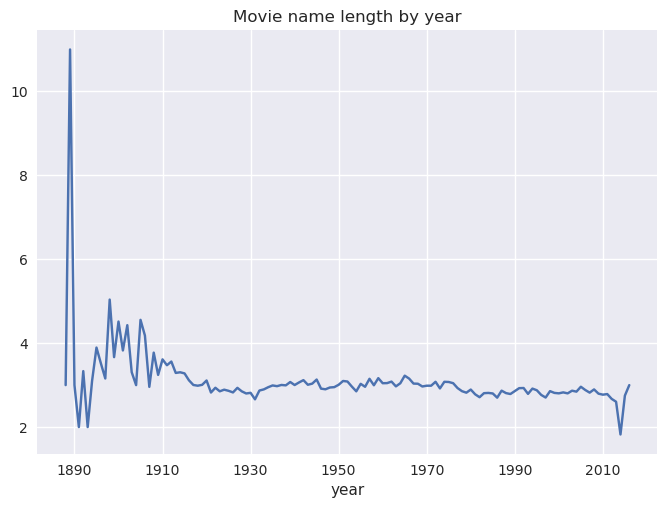

In [ ]:
with plt.style.context("seaborn-v0_8"):
    movies_processed["year"] = movies_processed["movie_release_date"].dt.year
    movies_processed["movie_name_len"] = movies_processed["movie_name"].apply(lambda x: len(x.split(" ")))
    movies_processed[["year", "movie_name_len"]].groupby("year")["movie_name_len"].mean().plot(x="year", y="movie_name_len", title="Movie name length by year")
    plt.xticks(ticks=[i for i in range(1890, 2021, 20)]);

Movie number by year. 

We see very fast increase of the number of films by year. Almost 5 times during 100 years

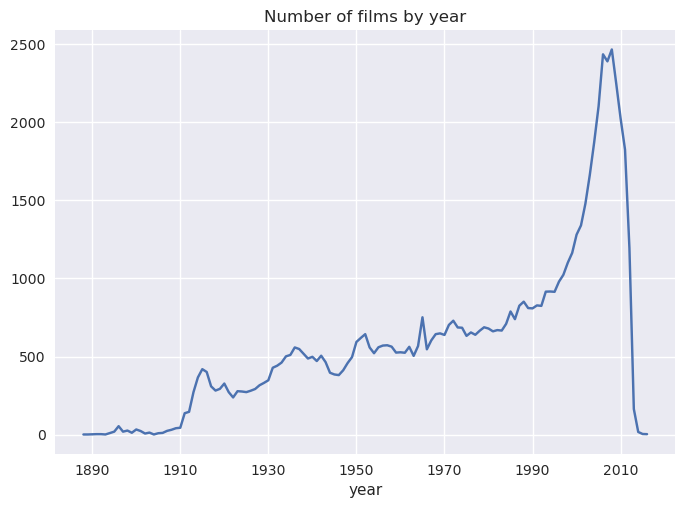

In [ ]:
with plt.style.context("seaborn-v0_8"):
    movies_processed["year"] = movies_processed["movie_release_date"].dt.year
    movies_processed[["year", "movie_name"]].groupby("year")["movie_name"].count().plot(x="year", y="movine_name", title="Number of films by year")
    plt.xticks(ticks=[i for i in range(1890, 2021, 20)]);

Revenue by the number of languages.

It decreases with the increase of the number of languages!

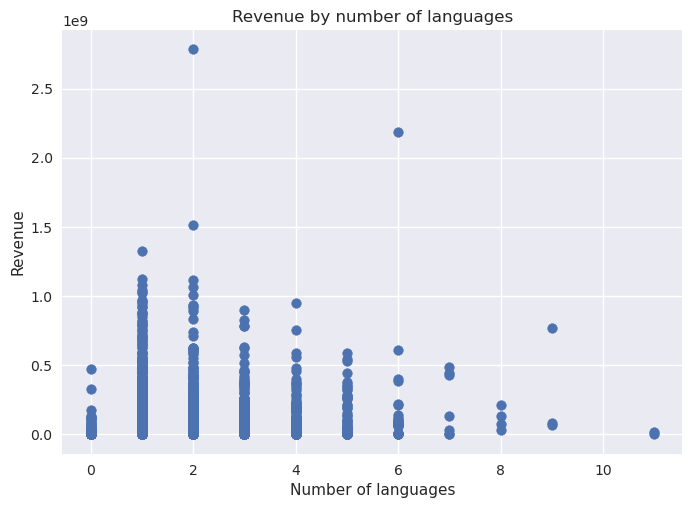

In [ ]:
with plt.style.context("seaborn-v0_8"):
    plt.title("Revenue by number of languages")
    plt.scatter(movies_processed["language_num"], movies_processed["revenue"])
    plt.xlabel("Number of languages")
    plt.ylabel("Revenue");

Most popular genre by country

In [ ]:
correspondeces_genre_country = {}

all_genres = set([i for j in movies_processed["genres"].values for i in eval(j)])
all_countries = set([i for j in movies_processed["countries"].values for i in eval(j)])

for g in all_genres:
    for c in all_countries:
        if not g in correspondeces_genre_country:
            correspondeces_genre_country[g] = {}
        correspondeces_genre_country[g][c] = 0

for _, row in tqdm(movies_processed[["genres", "countries"]].dropna().iterrows(), total=len(movies_processed)):
    genres_curr = eval(row['genres'])
    countries_curr = eval(row['countries'])
    for g in genres_curr:
        for c in countries_curr:
            correspondeces_genre_country[g][c] += 1

100%|██████████| 81741/81741 [00:36<00:00, 2220.43it/s]


The results are quite predictable. Drama in the majority of the countries and some country specific (like Chinese Cinema in China)

In [ ]:
correspondeces_genre_country_pd = pd.DataFrame(correspondeces_genre_country)
normalized_corres_gc = correspondeces_genre_country_pd.values / correspondeces_genre_country_pd.values.sum(axis=1)[:, None]
correspondeces_genre_country_pd["most_popular"] = correspondeces_genre_country_pd.columns[normalized_corres_gc.argmax(axis=1)]
print(correspondeces_genre_country_pd.sort_values("most_popular")["most_popular"].to_string())

Bhutan                            Adventure
China                        Chinese Cinema
Hong Kong                    Chinese Cinema
Taiwan                       Chinese Cinema
Argentina                           Classic
Malaysia                             Comedy
Uzbekistan                           Comedy
Czech                                Comedy
Crime                                 Crime
Qatar                           Documentary
Senegal                         Documentary
Congo                           Documentary
Ethiopia                        Documentary
Switzerland                           Drama
Denmark                               Drama
Peru                                  Drama
Zambia                                Drama
United States of America              Drama
Wales                                 Drama
Indonesia                             Drama
Cuba                                  Drama
Vietnam                               Drama
Bosnia and Herzegovina          

## Characters and movies dependencies

In [ ]:
data_merged_raw = char_processed.merge(movies_processed.drop(columns=["fb_movie_id", "movie_release_date"]), on="wikipedia_movie_id")

In [ ]:
# we do not need every column in our current analysis
data_merged = data_merged_raw[[
    'wikipedia_movie_id', 'character_name', 'actor_gender',
    'actor_height', 'fb_actor_eth_id', 'actor_name', 'fb_char_actor_map_id',
    'fb_char_id', 'fb_actor_id', 'actor_date_of_birth',
    'movie_release_date', 'ethn_name', 'race', 'movie_name', 'revenue',
    'movie_runtime', 'languages', 'countries_old', 'countries', 'genres',
    'year', 'language_num', 'genre_num', 'movie_name_len'
]]

Index(['wikipedia_movie_id', 'fb_movie_id', 'character_name', 'actor_gender',
       'actor_height', 'fb_actor_eth_id', 'actor_name', 'fb_char_actor_map_id',
       'fb_char_id', 'fb_actor_id', 'actor_date_of_birth',
       'movie_release_date', 'ethn_name', 'race', 'movie_name', 'revenue',
       'movie_runtime', 'languages', 'countries_old', 'countries', 'genres',
       'year', 'language_num', 'genre_num', 'movie_name_len'],
      dtype='object')

We can really look at a lot of dependencies between the revenue and actors (revenue and number of actors, revenue and races, revenue and actors heights, revenue and percentage of females, revenue and average age of actors and so on).
The same analysis can be made for movie_runtime.

But it is not the main part of our task so we just look at the depende between revenue and the number of actors.

We can see that there is a slight but statistically significant correlation.\
(We use spearman correlation because actors_count is non continuous)

SignificanceResult(statistic=np.float64(0.502382366433091), pvalue=np.float64(0.0))


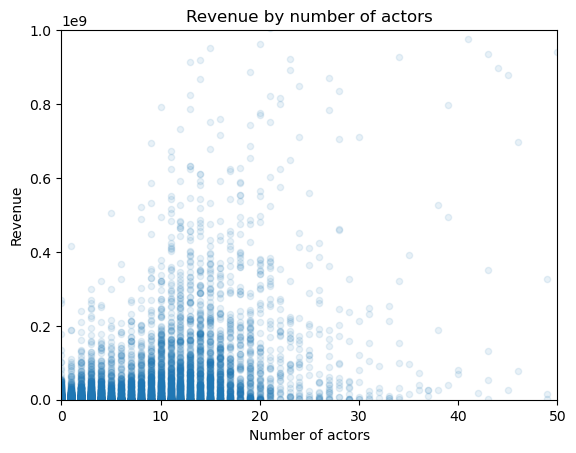

In [ ]:
from scipy.stats import spearmanr

revenue_by_actors_count = data_merged[["movie_name", "character_name"]]\
    .groupby(["movie_name"])\
    .count().reset_index().rename(columns={"character_name": "actors_count"})\
    .merge(movies_processed[["movie_name", "revenue"]], on="movie_name")[["actors_count", "revenue"]].dropna()

print(spearmanr(revenue_by_actors_count["actors_count"], revenue_by_actors_count["revenue"]))
revenue_by_actors_count.plot(x="actors_count", y="revenue", kind="scatter", alpha=0.1)
plt.xlim(0, 50)
plt.ylim(0, 1e9)
plt.title("Revenue by number of actors")
plt.xlabel("Number of actors")
plt.ylabel("Revenue");

It might be useful to make the correspondence matrix between countries and races. 

In [ ]:
correspondeces_race_country = {}

all_races = data_merged["race"].dropna().unique()
all_countries = set([i for j in data_merged["countries"].values for i in eval(j)])

for r in all_races:
    for c in all_countries:
        if not r in correspondeces_race_country:
            correspondeces_race_country[r] = {}
        correspondeces_race_country[r][c] = 0

for _, row in tqdm(data_merged[["race", "countries"]].dropna().iterrows(), total=len(data_merged)):
    race = row['race']
    for c in eval(row['countries']):
        correspondeces_race_country[race][c] += 1

 26%|██▌       | 86218/334987 [00:29<01:24, 2939.62it/s]


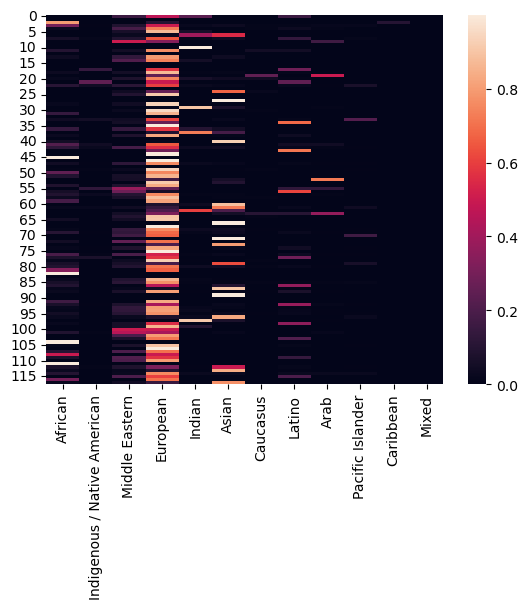

In [ ]:
correspondeces_race_country_pd = pd.DataFrame(correspondeces_race_country)
# normalize by sum of other races
normalized_corres = correspondeces_race_country_pd.values / (1e-6 + correspondeces_race_country_pd.values.sum(axis=1)[:, None])
sns.heatmap(normalized_corres)
plt.xticks(ticks=np.arange(0, 12) + 0.5, labels=correspondeces_race_country_pd.columns, rotation=90);

For every country look at the most popular race.\
*The results are quite predictable because the most popular races in movies are the same as the most popular race living in the country*

In [ ]:
correspondeces_race_country_pd["most_popular"] = correspondeces_race_country_pd.columns[normalized_corres.argmax(axis=1)]
print(correspondeces_race_country_pd.sort_values("most_popular")["most_popular"].to_string())

Cambodia                           African
Costa Rica                         African
Estonia                            African
Azerbaijan                         African
Jordan                             African
Qatar                              African
Congo                              African
Burkina Faso                       African
Senegal                            African
Mongolia                           African
Macau                              African
Kenya                              African
Ethiopia                           African
Crime                              African
Guinea                             African
Jamaica                            African
Mali                               African
Cameroon                           African
Iran                                  Arab
Armenia                               Arab
Egypt                                 Arab
Nepal                                Asian
South Korea                          Asian
Philippines

# Data enriching: actor & character features
Responsible: Andrew

---

To gather actors information, at this point, we will use `wikipediaapi`. 

Core logic is described in `src/scripts/actor_metadata_selection.py`.

This Python script extracts character and actor descriptions from Wikipedia using the wikipedia-api library. It processes a CSV file containing movie and actor data, retrieves relevant descriptions from Wikipedia, and appends them to a new dataset.

The script uses the WikipediaMetadataSelectorForActor class to handle the extraction and several supporting functions for data reading, processing, and writing.

The main methods are:

- `extract_character_description`
    - Given a movie_id and a character_name, this method retrieves the Wikipedia page for the movie and searches for the "Plot" section.
    - It splits the plot into sentences and finds those containing the character's name.
    - If a sentence is found, it returns the first sentence mentioning the character.
- `extract_actor_description`
    - Given an actor_name, this method retrieves the actor's Wikipedia page and extracts the first significant paragraph (longer than 50 characters).
    - The paragraph is truncated if it's too long.

Using this logic, information for actors and characters extracted. Here's an example of how to use the tool:

```bash
python ./src/scripts/actor_metadata_selection.py \
    --data_dir <path1> \
    --output_dir <path2> \
    --n_rows 100
```

Enriched csv file is comited to this repository as processing takes some time. Let's take a look at it.

In [ ]:
import pandas as pd

df = pd.read_csv('./data/MovieSummaries/character_processed_enriched.csv')
df = df[['character_name', 'actor_name', 'character_description', 'actor_description']][1:]
df

,character_name,actor_name,character_description,actor_description
1,Akooshay,Wanda De Jesus,NaN,"Wanda De Jesus (born August 26, 1958) is an Am..."
2,Lieutenant Melanie Ballard,Natasha Henstridge,NaN,"Natasha Tonya Henstridge (born August 15, 1974..."
3,Desolation Williams,Ice Cube,NaN,"O'Shea Jackson Sr. (born June 15, 1969), known..."
4,Sgt Jericho Butler,Jason Statham,NaN,Jason Statham ( STAY-thəm; born 26 July 1967) ...
5,Bashira Kincaid,Clea DuVall,NaN,Clea Helen D'Etienne DuVall (born September 25...
...,...,...,...,...
95,NaN,M. G. Soman,NaN,M. G. Soman (28 October 1941 – 12 December 199...
96,NaN,Nedumudi Venu,NaN,Kesavan Venugopal (22 May 1948 – 11 October 20...
97,Lucy,Ruby Lin,NaN,Ruby Lin Xin-ru (Chinese: 林心如; pinyin: Lín Xīn...
98,Sophie,Zhang Ziyi,NaN,Zhang Ziyi ([ʈʂáŋ tsɹ̩̀.ǐ]; Chinese: 章子怡; born...


We can see that for actors descriptions a lot of additional data was found

In [52]:
df[~df.actor_description.isna()]

,character_name,actor_name,character_description,actor_description
1,Akooshay,Wanda De Jesus,NaN,"Wanda De Jesus (born August 26, 1958) is an Am..."
2,Lieutenant Melanie Ballard,Natasha Henstridge,NaN,"Natasha Tonya Henstridge (born August 15, 1974..."
3,Desolation Williams,Ice Cube,NaN,"O'Shea Jackson Sr. (born June 15, 1969), known..."
4,Sgt Jericho Butler,Jason Statham,NaN,Jason Statham ( STAY-thəm; born 26 July 1967) ...
5,Bashira Kincaid,Clea DuVall,NaN,Clea Helen D'Etienne DuVall (born September 25...
...,...,...,...,...
95,NaN,M. G. Soman,NaN,M. G. Soman (28 October 1941 – 12 December 199...
96,NaN,Nedumudi Venu,NaN,Kesavan Venugopal (22 May 1948 – 11 October 20...
97,Lucy,Ruby Lin,NaN,Ruby Lin Xin-ru (Chinese: 林心如; pinyin: Lín Xīn...
98,Sophie,Zhang Ziyi,NaN,Zhang Ziyi ([ʈʂáŋ tsɹ̩̀.ǐ]; Chinese: 章子怡; born...


# Data enriching: movie features
Responsible: Kirill A

---

Here we will make the similar pipeline, as in enriching actor & character features, using ``wikipediaapi``.
The explanations are presented in ``src/scripts/movie_metadata_selection.py``.

The script extracts movie metadata from Wikipedia using the wikipedia-api library and produces ``.csv`` file containing movie metadata, retrieving relevant descriptions from Wikipedia, and after appends them to a new dataset.

The script uses the WikipediaMetadataSelectorForMovie class to handle the extraction and several supporting functions for data reading, processing, and writing.

The main method is:

- `extract_metadata_description`
    - Given a movie_id, this method retrieves the Wikipedia page for the movie and searches for the "(Top)" section and parses the Release date, Genre and cast by using the keywords
    - Then it searches for the "Plot" section and retrieves the ``plot_summary``
 
You can use this tool with:

```bash
python ./src/scripts/movie_metadata_selection.py \
    --data_dir <path1> \
    --output_dir <path2> \
    --n_rows 100
```

The file ``movie_processed_enriched.csv`` is commited to the repository. Let's take a look at it:

In [8]:
! python ../scripts/movie_metadata_selection.py --n_rows 10 --data_dir ../../data/MovieSummaries --input_file_name movie_processed_v2.csv

Starting movie data enrichment...
Input file: ../../data/MovieSummaries/movie_processed_v2.csv
Output file: /Users/alexdremov/DocumentsLocal/StudyLocal/epfl/ada/project/src/notebooks/data/MovieSummaries/movie_processed_enriched.json
Processing 10 rows
Processing 10 rows...
Index(['Wikipedia movie ID', 'Freebase movie ID', 'Movie name',
       'Movie box office revenue', 'Movie runtime', 'languages',
       'movie_release_date', 'countries_old', 'countries', 'genres',
       'wiki_api_title'],
      dtype='object')
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1231.23it/s]
Enrichment complete! Check movie_enrichment.log for details.


Data for movies is gathered this way. The final summaries can be found in `data/MovieSummaries/summaries.json` (check `data/MovieSummaries/load.sh`)

The summaries are simply assembled from data gathered from wiki (can be found in `src/notebooks/process_enriched_movies.ipynb`)

`movie_processed_v2.csv` is made by converting wiki id to wiki title, which is used to fetch data from wiki about the movie

# Freebase

Freebase data is used to gather information about actors, as the provided data is incomplete. 

We use the whole data dump (3 billion entries) and grep entries with relevant ids (aka actor freebase id). The processing code may be found in 
`src/notebooks/freebase_reader.ipynb` and `src/notebooks/freebase_movies.ipynb`.

The result of processing can be found in `data/enriched/actors`

In [11]:
import pandas as pd

pd.read_csv('../../data/enriched/actors/actors_freebase.csv').head(3)

,Unnamed: 0,education,count_guest_roles,places_lived,spouses,children,professions_num,professions,date_of_birth,nationality,...,discription,id,wiki_en_path,wiki_en_title,wiki_en_page,wiki_en_id,height,religion,weight,freebase_to_wiki_title
0,0,False,0,0,0,0,1,['Actor'],1970-01-02,Germany,...,Chris Hohenester is a German actress.,/m/0j50vrd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chris Hohenester
1,1,False,0,1,0,0,5,"['Screenwriter', 'Comedian""-GB', 'Writer', 'Fi...",1960-02-27,United States of America,...,"Mary Joseph \""Mary Jo\"" Pehl is an American wr...",/m/03xmr6,/wikipedia/en/Mary_Jo_Pehl,Mary_Jo_Pehl,http://en.wikipedia.org/wiki/index.html?curid=...,995072.0,NaN,NaN,NaN,Mary Jo Pehl
2,2,True,14,1,0,0,5,"['Voice acting""-GB', 'Actor', 'Comedian""-GB', ...",1978-11-23,United Kingdom,...,"Kayvan Novak is a British-Iranian actor, voice...",/m/0gwpbl,/wikipedia/en_id/6912128,Kayvan_Novak,http://en.wikipedia.org/wiki/Kayvan_Novak,6912128.0,1.85,NaN,NaN,Kayvan Novak


# Archetype inference
Responsible: Kirill Z

---

Configs and model requests code can be found in `./src/models`

To use model, credentials file for Google API should be provided. They give money for API use, so we have not spent real money for the project (yet)

In [ ]:
import os
import sys

GLOUD_CREDENTIALS = "<path to credentials.json>"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GLOUD_CREDENTIALS

To evaluate model's perfomance we will use dataset provided as part of the `Learning Latent Personas of Film Characters` paper.

The article made a test set of 500 examples. To do this, they went to the tvtropes website, and took 72 archetypes, for example https://tvtropes.org/pmwiki/pmwiki.php/Main/TheChanteuse

The authors gathered a dataset of 500 examples. Using these 500 examples, we will tune the model. We split the data into the train/test/validation in the proportion (300/50/150). The comited `personal_identification_test_set.csv` is test set of the splitted data.

Then we took a sample of 20 different examples from the train and selected a reasonable prompt.
Using this prompt, we form a train set and validation set, and tune the LM on google cloud platform.

You can find the training notebook at `src/notebooks/kirill456z-experiments.ipynb`

In [ ]:
import pandas as pd

test_df = pd.read_csv("./data/persona_identification/persona_identification_testset.csv", index_col="index")
test_df

,character_name,movie_name,persona,movie_summary
index,,,,
5,Ellen Aim,Streets of Fire,chanteuse,"In an unnamed city, Ellen Aim , lead singer of..."
15,Timothy,The Long Kiss Goodnight,casanova,Samantha Caine is a mother and schoolteacher ...
16,Johnny Wickham,Bride and Prejudice,casanova,The plot of the movie is based on Austen′s nov...
26,Roy O'Bannon,Shanghai Noon,retired_outlaw,Chon Wang is a Chinese imperial guard. After P...
36,Jackson Rippner,Red Eye,psycho_for_hire,After attending her grandmother's funeral in D...
...,...,...,...,...
496,Lt. Commander Ron Hunter,Crimson Tide,father_to_his_men,"In post-Soviet Russia, military units loyal to..."
497,Christopher Pike,Star Trek,father_to_his_men,"In 2233, the Federation starship USS Kelvin is..."
498,Zordon,Mighty Morphin' Power Rangers: The Movie,father_to_his_men,"The Power Rangers, Adam , Kimberly , Billy , A..."


Here's the code of trained model inference

In [ ]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from src.models.persona_identification import PersonaIdentification
from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache
from langchain_redis import RedisCache

# to cache requests to LM, consider using remote redis server
cache = InMemoryCache()
# cache = RedisCache(redis_url="redis://localhost:6379")
set_llm_cache(cache)

rate_limiter = InMemoryRateLimiter(
    requests_per_second=4.99 / 60,  # free google cloud account allows 5 requests per minute
    check_every_n_seconds=0.1,
    max_bucket_size=5,
)

pi = PersonaIdentification(
    config_path="./src/models/persona_identification_config.yaml",
    cache=cache,
    rate_limiter=rate_limiter,
)

test_df_results = pi.batch(test_df.to_dict(orient="records"))

/var/folders/d_/x1jfcqpx1cl4zcrx9bzpclq00000gn/T/ipykernel_61279/1898440038.py:11: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


In [ ]:
test_df_results[0]

AIMessage(content='Chanteuse', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 1331, 'candidates_token_count': 4, 'total_token_count': 1335, 'cached_content_token_count': 0}, 'finish_reason': 'STOP', 'avg_logprobs': -0.005151043180376291, 'logprobs_result': {'top_candidates': [], 'chosen_candidates': []}, 'parsing_success': True}, id='run-efcef1dc-d731-4207-9e99-368a422cc09c-0', usage_metadata={'input_tokens': 1331, 'output_tokens': 4, 'total_tokens': 1335})

In [ ]:
from src.models.persona_identification import persona_lowercase
from sklearn.metrics import precision_score, recall_score, f1_score

test_df["model_predictions"] = [persona_lowercase(res.content) for res in test_df_results]
test_df["is_prediction_valid"] = [1 if res.response_metadata["parsing_success"] else 0 for res in test_df_results]

print("Not valid predictions:")
display(test_df[test_df.is_prediction_valid == 0])
print(f"Prediction accuracy: {(test_df.model_predictions == test_df.persona).mean(): .3f}")

micro_f1 = f1_score(test_df['persona'],test_df['model_predictions'], average='micro')
macro_f1 = f1_score(test_df['persona'],test_df['model_predictions'], average='macro')
print(f"Micro f1: {micro_f1:.2f}")
print(f"Macro f1: {macro_f1:.2f}")

test_df.to_excel("model_predictions_analysis.xlsx");

Not valid predictions:


,character_name,movie_name,persona,movie_summary,model_predictions,is_prediction_valid
index,,,,,,
322,Michael Newman,Click,ditz,"Michael Newman , an architect, is married to h...",workaholic\n\n,0
448,The Lieutenant,Bad Lieutenant,dirty_cop,"The film opens in the Bronx, where The Lieuten...",,0


Prediction accuracy:  0.426
Micro f1: 0.43
Macro f1: 0.30


We see that the model works, and considering high number of classes, actually not bad. 



# Data Story Code

Our data story is purely data-driven. The following code is precisely the code our data story is generated from (with cells removed from the data story)